In [1]:
#Authors: Eli Gumble, Peter Brommer, Harry Brown
#Initialisation
import matplotlib.pyplot as plt
import matplotlib.mlab as mmlab
import numpy as np
from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline 
from numpy import ma
from matplotlib import colors, ticker, cm
from random import choice
import timeit

%matplotlib inline
from PIL import Image

In [2]:
# Read grids from image
im = Image.open("cc_fin.bmp")
pic = np.array(im)


In [3]:
scale = 0.25 #m per pixel
Nx = pic[:,0,0].size #N appears to be resolution
Ny = pic[0,:,0].size
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
tr = np.zeros((Nx,Ny))
destp=np.zeros((Nx,Ny))
wght=np.zeros((Nx,Ny))
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
#desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
#desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
intens[:]=0.

#print(route)
#parameters
t_track=50.
dt=0.1
dvel=1.
tau=5.
isigma=1./4.
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all

In [4]:
##Set up map


#Create blank arrays
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny))
g_nat=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(pic[:,:,0]))
g_max=np.maximum(np.ones_like(g_max),np.float64(pic[:,:,1]))
z=g_nat

track_labels=pic[:,:,2];

numpoints=np.max(track_labels)

point=np.zeros((numpoints,2))

for i in range(0,Nx):
    for j in range(0,Ny):
        if (track_labels[i,j]>0):
            point[track_labels[i,j]-1]=np.array([i,j])

#define initial and max ground potentials
#z[:,:]=1.
#g_max[:,:]=80.
#Set ground potentials
#z[35:200,15:40]=100;z[50:120,70:85]=100;z[80:110,85:120]=100;z[0:20,70:120]=100;z[20:50,40:95]=100;
#g_max[35:200,15:40]=100;g_max[50:120,70:85]=100;g_max[80:110,85:120]=100;g_max[0:20,70:120]=100;g_max[20:50,40:95]=100;
#z[120:201,70:85]=80;
#z[50:200,40:70]=30;
#z[100:200,85:120]=30;
#g_nat=z

print (point)

# Trails (start and end point)
route=np.array([[[-2.5,14.],[24.,-9.75]],
                [[-2.5,14.],[24.,2.5]],
                [[-2.5,14.],[-24.,9.75]],
                [[24.,-9.75],[-2.75,14.]],
                [[24.,-9.75],[-24.,9.75]],
                [[24.,2.5],[-2.75,14.]],
                [[24.,2.5],[-24.,9.75]],
                [[-24.,10.],[-2.75,14.]],
                [[-24.,10.],[24.,-9.75]],
                [[-24.,10.],[24.,2.5]]])

[[450.  67.]
 [449. 347.]
 [449.  69.]
 [449. 345.]
 [449. 344.]
 [449. 343.]
 [449. 367.]
 [449. 350.]
 [450. 271.]
 [450. 349.]
 [449. 264.]
 [449. 265.]
 [450. 350.]
 [450. 348.]
 [449. 266.]
 [450. 351.]
 [450. 345.]
 [450. 343.]
 [449. 368.]
 [449. 267.]
 [450. 255.]
 [450. 254.]
 [449. 369.]
 [448. 351.]
 [415. 246.]
 [450. 367.]
 [445. 370.]
 [450. 257.]
 [450. 264.]
 [450. 252.]
 [450. 265.]
 [450. 266.]
 [450. 369.]
 [450. 268.]
 [411. 370.]
 [448. 246.]
 [450. 247.]
 [  0.   0.]
 [ 94. 328.]
 [312. 337.]
 [  0.   0.]
 [410. 338.]
 [ 95. 315.]
 [  0.   0.]
 [316. 337.]
 [  0.   0.]
 [315. 337.]
 [  0.   0.]
 [274. 338.]
 [450. 370.]
 [ 94. 334.]
 [ 95. 190.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 314.]
 [  0.   0.]
 [ 95. 309.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 308.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 336.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]

In [5]:
#Setup weight matrix, here trapezoid rule.
wght[:,:]=1
wght[1:-1,:]=2
wght[:,1:-1]=2
wght[1:-1,1:-1]=4
wght*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]


In [6]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):
        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]
        
# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>convthresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape

(221, 221)

In [7]:
def calc_tr_new():
    tr[:,:]=sg.convolve2d(z[:,:]*wght[:,:],subexpdist[:,:],mode="same")

In [8]:
#Integrate z, trapezoid rule eq 20
def calc_tr():
    global xi,yi,tr,expdist,z,wght,Nx,Ny
    for xi in range(0,Nx): 
        for yi in range(0,Ny):
            tr[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*wght[:,:])

In [9]:
#timeit.timeit(calc_tr,number=1)

In [10]:
timeit.timeit(calc_tr_new,number=1)

31.792743500000004

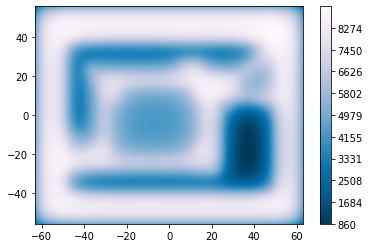

In [11]:
# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)
#calc_tr()

# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
cs = plt.contourf(X, Y, tr, levels=np.linspace(tr.min(),tr.max(),1000),cmap=cm.PuBu_r)

# Alternatively, you can manually set the levels
# and the norm:
#lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
#levs = np.power(10, lev_exp)
#cs = plt.contourf(X, Y, z, levs, norm=colors.LogNorm())

# The 'extend' kwarg does not work yet with a log scale.

cbar = plt.colorbar()
#plt.scatter(track[0:1999,0],track[0:1999,1])
plt.show()

In [12]:
#set up walker
def set_up_walker(route_id):
    global vel,pos,track,intens,dest,start,route
    #start
    start=np.array(route[route_id,0,:])
    #dest=(random.choice(ends))
    dest=np.array(route[route_id,1,:])
    vel=np.array([0.,0.])
    pos=np.array(start)
    #print (pos)
    track=np.zeros((2000,2))
#    track[0,:]=pos[:]
#

In [13]:

#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest
    grad=0.002*np.array(np.gradient(tr))

    #print (dest)
#Destination 

#def choose_start()
 #   start=(random.choice(starts))
#def choose_dest()
 #   dest=(random.choice(ends))
#Destination potential
    destp=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
#Combine gradients
    grad+=np.array(np.gradient(destp)[:])
#Normalise
#grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)

NameError: name 'track' is not defined

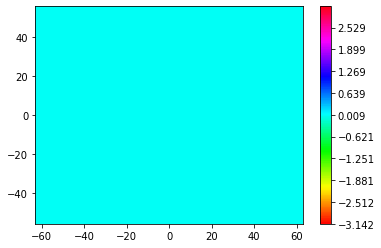

In [14]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap=cm.hsv)

cbar = plt.colorbar()
plt.scatter(track[0:1999,0],track[0:1999,1])
plt.show()


In [ ]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau;
#    for i in range(0,399):
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    while (np.dot(pos-dest,pos-dest)>precision and i<2000):
    #Integrator eq 5
        pos+=dt*vel
        if (i%samp==0): avpos[:,(i%hist)//samp]=pos[:]
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        vel[0]+=-1/tau*vel[0]+(dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]
        vel[1]+=-1/tau*vel[1]+(dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        #print (i,pos,vel,(dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude,(dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude)
        track[i,:]=pos[:]
        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision): 
                print ("Stalled progress ",pos,meanpos,vel)
                break
    if (i==2000): print ("Missed goal ",dest,pos)           
    return i    
#stopping condition    

In [ ]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
# Time evolution of ground potential
#    zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
#    cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
#    cbar = plt.colorbar()
#    plt.show
#    z[140:160,45:75]

In [15]:
def plot_path():
    cs = plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap=cm.PuBu_r)
    cbar = plt.colorbar()
    plt.show
    plt.scatter(track[0:1999,0],track[0:1999,1])

In [16]:
ymin

-55.75

In [17]:
for i in range(0,2):
    calc_tr_new()
    intens[:]=0.
    for j in range(0,10):
        set_up_walker(np.random.randint(0,len(route)))
        setup_potentials()
        print (i, start," -> ", dest, pos, calc_path())
    update_ground()
    #plot_path()

NameError: name 'calc_path' is not defined

In [ ]:
precision=1.

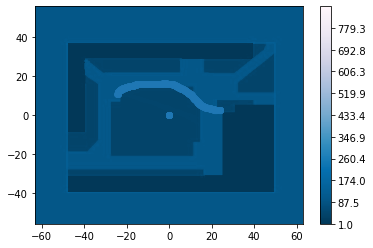

In [21]:
plot_path()

In [ ]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],pic[i,j,0])
        

In [ ]:
g_nat[:,:]-pic[:,:,0]

In [ ]:
z.dtype